# Transfer Learning Sentiment Model 
###### Importing dependencies

In [1]:
#applicazione modello a tweet giugno-agosto 2020 3 città e confronto con sentiment da textblob + estrazione mese, giorno, ora
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.express as px
import re
import nltk
import pickle

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, RepeatVector
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop
from keras.layers import LSTM, TimeDistributed
import re

import matplotlib.pyplot as plt
%matplotlib inline

###### Import Dataset

In [3]:
df= pd.read_csv("../Preprocessing/sahel_jun_aug_2020_en_all_clear_date_polarity.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      34868 non-null  int64 
 1   created_at      34868 non-null  object
 2   date            34868 non-null  object
 3   time            34868 non-null  object
 4   year            34868 non-null  int64 
 5   month           34868 non-null  int64 
 6   day             34868 non-null  int64 
 7   hour            34868 non-null  int64 
 8   city            34868 non-null  object
 9   tweet           34868 non-null  object
 10  polarity        34868 non-null  object
 11  processed_text  34868 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.2+ MB


In [4]:
df = df.drop(df.columns[[0]], axis=1) 

In [5]:
df

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...
...,...,...,...,...,...,...,...,...,...,...,...
34863,2020-06-01 03:39:08 CEST,2020-06-01 00:00:00,2021-11-14 03:39:08,2020,6,1,3,Ouagadougou,"@ifeafolayann I agree with this, because it ta...",pos,<user> i agree with this because it take a ma...
34864,2020-06-01 03:29:14 CEST,2020-06-01 00:00:00,2021-11-14 03:29:14,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor Advice***,pos,<user> <user> advice
34865,2020-06-01 03:27:08 CEST,2020-06-01 00:00:00,2021-11-14 03:27:08,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor If this advise c...,pos,<user> <user> if this advise can prevent futur...
34866,2020-06-01 03:22:43 CEST,2020-06-01 00:00:00,2021-11-14 03:22:43,2020,6,1,3,Ouagadougou,@Ms_Haesha @OoasWaho @DrTedros @MoetiTshidi @J...,pos,<user> <user> <user> <user> <user> <user> <use...


In [6]:
df['processed_text']

0               <user> wlhy or                            
1          jishaq1 <user> haba bross do not fall for ou...
2                                 <user>   stresses ne 2k 
3                      <user>                         idk 
4        <user> <user>                                 ...
                               ...                        
34863    <user> i agree with this  because it take a ma...
34864                              <user> <user> advice   
34865    <user> <user> if this advise can prevent futur...
34866    <user> <user> <user> <user> <user> <user> <use...
34867                                            with pgi 
Name: processed_text, Length: 34868, dtype: object

##### Loading saved Model for transfer

In [7]:
import tensorflow as tf
mymodel = tf.keras.models.load_model('../ModelForTransfer/Sentiment-BiLSTM')

###### Test set

In [8]:
X_test = df['processed_text']

In [9]:
df['processed_text'][1000]

'today to you tomorrow to your brother <url> '

In [10]:
df['processed_text'][551]

'<user>   fcomomradee11 yess type of jamban '

In [11]:
df['processed_text'][1001]

'<user> how d you know there      s mai inside          '

In [12]:
df['processed_text'][1002]

'<user> it is actually the v  p who proposed it '

In [13]:
df['processed_text'][1003]

'do you know that perfume have the power to calm you regardless of your anger   unguwar rogo area sokoto <url> '

In [14]:
df['processed_text'][900]

'your breasts and your heart lights makes you understand the light lights          '

In [15]:
X_test

0               <user> wlhy or                            
1          jishaq1 <user> haba bross do not fall for ou...
2                                 <user>   stresses ne 2k 
3                      <user>                         idk 
4        <user> <user>                                 ...
                               ...                        
34863    <user> i agree with this  because it take a ma...
34864                              <user> <user> advice   
34865    <user> <user> if this advise can prevent futur...
34866    <user> <user> <user> <user> <user> <user> <use...
34867                                            with pgi 
Name: processed_text, Length: 34868, dtype: object

###### Transfer Model Architecture

In [16]:
mymodel.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           27283600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

###### Loading previous saved Tokenizer and Updating vocabulary

In [17]:
# Loading model to compare the results
model_tok = pickle.load(open('../ModelForTransfer/Tokenizer.pickle','rb'))

In [18]:
#previous vocabulary length
voc_len_model = len(model_tok.word_index) + 1
print("Tokenizer vocab length:", voc_len_model)

Tokenizer vocab length: 272836


In [19]:
model_tok.word_index

{'<oov>': 1,
 'i': 2,
 '<user>': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'is': 7,
 'my': 8,
 'it': 9,
 'and': 10,
 'you': 11,
 'not': 12,
 'in': 13,
 'for': 14,
 'of': 15,
 'am': 16,
 'have': 17,
 'on': 18,
 'me': 19,
 'so': 20,
 'that': 21,
 'but': 22,
 'just': 23,
 'do': 24,
 'with': 25,
 'be': 26,
 'at': 27,
 'are': 28,
 'was': 29,
 'will': 30,
 'this': 31,
 'now': 32,
 'good': 33,
 'up': 34,
 'going': 35,
 'day': 36,
 'all': 37,
 'out': 38,
 'get': 39,
 'like': 40,
 'no': 41,
 '<url>': 42,
 'go': 43,
 'got': 44,
 'quot': 45,
 'too': 46,
 'today': 47,
 'your': 48,
 'work': 49,
 'love': 50,
 'we': 51,
 'lol': 52,
 'want': 53,
 'time': 54,
 'back': 55,
 'from': 56,
 'u': 57,
 'what': 58,
 'know': 59,
 'one': 60,
 'im': 61,
 'about': 62,
 'really': 63,
 'had': 64,
 'cannot': 65,
 'amp': 66,
 'can': 67,
 'did': 68,
 'see': 69,
 'some': 70,
 'its': 71,
 'how': 72,
 'if': 73,
 'still': 74,
 'they': 75,
 'night': 76,
 'well': 77,
 '2': 78,
 'new': 79,
 'think': 80,
 'home': 81,
 'thanks': 82,
 '

In [20]:
tokenizer = model_tok

In [21]:
tokenizer.fit_on_texts(X_test)

In [22]:
#new vocabulary length
vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 287618


In [23]:
tokenizer.word_index

{'<oov>': 1,
 'i': 2,
 '<user>': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'is': 7,
 'my': 8,
 'you': 9,
 'it': 10,
 'and': 11,
 'not': 12,
 'in': 13,
 'for': 14,
 'of': 15,
 'am': 16,
 'have': 17,
 'on': 18,
 'me': 19,
 'so': 20,
 'that': 21,
 'but': 22,
 'just': 23,
 'do': 24,
 'with': 25,
 'be': 26,
 'are': 27,
 'at': 28,
 'was': 29,
 'will': 30,
 'this': 31,
 'now': 32,
 'good': 33,
 'up': 34,
 'going': 35,
 'day': 36,
 'all': 37,
 '<url>': 38,
 'out': 39,
 'get': 40,
 'like': 41,
 'no': 42,
 'go': 43,
 'got': 44,
 'too': 45,
 'your': 46,
 'today': 47,
 'quot': 48,
 'we': 49,
 'work': 50,
 'love': 51,
 'want': 52,
 'lol': 53,
 'time': 54,
 'back': 55,
 'from': 56,
 'u': 57,
 'what': 58,
 'know': 59,
 'one': 60,
 'about': 61,
 'really': 62,
 'im': 63,
 'had': 64,
 'can': 65,
 'amp': 66,
 'cannot': 67,
 'see': 68,
 'did': 69,
 'some': 70,
 'its': 71,
 'if': 72,
 'how': 73,
 'they': 74,
 'still': 75,
 'night': 76,
 'well': 77,
 '2': 78,
 'new': 79,
 'think': 80,
 'thanks': 81,
 'home': 82,
 '

In [25]:
input_length = 60
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

In [26]:
X_test

array([[     0,      0,      0, ...,      3,  27404,    104],
       [     0,      0,      0, ...,     14,    180,   1124],
       [     0,      0,      0, ...,  19345,   2992,  10825],
       ...,
       [     0,      0,      0, ...,    238,    188,    118],
       [     0,      0,      0, ...,     10,    889,    143],
       [     0,      0,      0, ...,      0,     25, 287617]], dtype=int32)

In [27]:
X_test.shape

(34868, 60)

In [28]:
X_test[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     3, 27404,   104], dtype=int32)

In [29]:
df['processed_text'][0]

'<user> wlhy or                            '

In [30]:
X_test[1548]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            3,   1493, 113922,  13315,  31356,     96,   2013,      6,
          845,   1530,      4,     19], dtype=int32)

In [31]:
df['processed_text'][1548]

'<user> allah songsa satan lob has received a different style to me '

In [32]:
df['processed_text'][30278]

'<user> if this is to condemn activists who militate against injustice and others is not normal to judge those who corrupt public money  or is there a concealed account regulation  '

In [33]:
X_test[30278]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      3,     72,
           31,      7,      4,  28264,  22984,    164, 286152,   1280,
        20239,     11,   1047,      7,     12,   1169,      4,   3598,
          279,    164,  10788,   1630,    411,    104,      7,     86,
            6,  41037,    746,  23923], dtype=int32)

In [34]:
df['processed_text'][2108]

'<user> <user> no one is happy about southern kaduna killings or anywhere else killings but your likes seems to personalize it and translate it to your own rational thinking  '

In [35]:
X_test[2108]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     3,     3,    42,    60,     7,
         119,    61,  4234, 18746, 20039,   104,  1380,   481, 20039,
          22,    46,  1323,   489,     4, 42335,    10,    11,  6308,
          10,     4,    46,   488, 22030,   386], dtype=int32)

In [36]:
X_test[100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 2083,  270,  217,
          9, 8249,   70,  203,   38], dtype=int32)

In [37]:
df['processed_text'][100]

'fear god before you utter some something  <url> '

In [38]:
X_test[1093]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,  26646,   9851,     68,
            5, 113897,      7,     12], dtype=int32)

In [39]:
df['processed_text'][1093]

'metrics toh see the bagware is not          '

In [40]:
X_test[1]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0, 275890,      3,  13881,  80346,     24,     12,
          679,     14,    180,   1124], dtype=int32)

In [41]:
df['processed_text'][1]

'  jishaq1 <user> haba bross do not fall for our hands '

### Load pre-trained Word2Vec Model

In [206]:
from sklearn.manifold import TSNE

In [53]:
# Load the word2vec model saved.
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

Embedding_dimensions = 100
model1 = KeyedVectors.load("../ModelForTransfer/Word2Vec-twitter-100")

In [45]:
vocab_len = len(model1)
print("Vocabulary Length:", vocab_len)

Vocabulary Length: 52025


In [252]:
model1.most_similar('criminal')

[('inquiring', 0.7030943632125854),
 ('remake', 0.5783006548881531),
 ('romance', 0.545769989490509),
 ('dubbed', 0.5452056527137756),
 ('quot<lolface>ushing', 0.5403376817703247),
 ('beethoven', 0.5370694398880005),
 ('rifftrax', 0.5315990447998047),
 ('pulp', 0.5302838683128357),
 ('fantasy', 0.5283020734786987),
 ('turkish', 0.52677983045578)]

In [255]:
model1.most_similar('islam')

[('rollins', 0.7017791271209717),
 ('intercourse', 0.6964032053947449),
 ('christianity', 0.6949958205223083),
 ('avenged', 0.6823639273643494),
 ('unison', 0.680046558380127),
 ('klingon', 0.6772092580795288),
 ('tante', 0.6771359443664551),
 ('sexes', 0.6748213171958923),
 ('mysteries', 0.674505352973938),
 ('defenseless', 0.6712925434112549)]

In [46]:
model1.most_similar('sky')

[('skies', 0.7556880116462708),
 ('cloud', 0.7126186490058899),
 ('light', 0.6853689551353455),
 ('clouds', 0.6625418066978455),
 ('breeze', 0.6361109018325806),
 ('ocean', 0.6311255693435669),
 ('fog', 0.6279910206794739),
 ('wind', 0.625325620174408),
 ('blue', 0.6150975227355957),
 ('sunlight', 0.6035239696502686)]

In [47]:
model1['sky']

array([-1.0878134 , -2.2121925 , -0.8818257 , -0.6323288 ,  0.10696227,
        0.9218052 ,  0.4583516 ,  1.4285244 ,  2.3905497 ,  2.0079198 ,
        0.58277357,  1.3408622 ,  0.11954723,  1.4560452 ,  0.67637694,
        0.2674041 ,  0.92671174, -3.4537165 ,  0.2813622 , -1.1155888 ,
       -0.04924822,  0.79306483, -0.02600059, -0.72774416, -2.3000965 ,
       -2.200919  , -1.8141062 , -0.3037002 , -0.8985982 ,  1.3085659 ,
        0.05015841, -0.83320796, -0.64401466, -0.9635886 ,  0.53565335,
        1.785141  , -0.14348842, -0.67988676,  0.34672192,  2.2641385 ,
        0.10773911, -0.2633837 , -0.19310905, -1.2900958 , -0.3495545 ,
       -0.1630398 ,  1.0717725 ,  1.143535  , -0.78267354, -0.43677804,
       -0.43921086, -1.9417651 ,  1.1154716 ,  1.3008071 , -0.36452323,
       -1.4784915 , -2.7725596 , -0.3531199 ,  1.510377  , -0.2292782 ,
        2.22253   , -0.8271041 ,  2.9012775 ,  0.6313764 , -2.076776  ,
        0.31962553, -0.06136416, -0.32037354, -0.5655746 ,  0.27

In [49]:
model1.most_similar('allah')

[('sembuh', 0.718144953250885),
 ('skrg', 0.7093959450721741),
 ('doain', 0.7004194259643555),
 ('boleh', 0.6960546970367432),
 ('tak', 0.6927961111068726),
 ('lai', 0.6876770257949829),
 ('nangis', 0.6875835657119751),
 ('rabu', 0.6866321563720703),
 ('udh', 0.685515284538269),
 ('cepet', 0.6843137741088867)]

In [50]:
model1['allah']

array([-1.20574504e-01,  3.84310603e-01,  7.71694779e-02, -4.84522134e-02,
        9.21778083e-02, -4.08357799e-01, -2.07777962e-01,  6.24964952e-01,
       -5.41577280e-01,  1.00318410e-01, -2.63520237e-02, -6.97897434e-01,
       -1.88841239e-01,  2.23809779e-01,  6.16408363e-02, -6.15700672e-04,
        1.65875256e-01, -6.08696043e-02,  1.61170010e-02, -3.66927564e-01,
        1.26555622e-01, -8.85354634e-03, -1.11875460e-01, -6.06783293e-02,
        2.85008281e-01,  9.55425762e-03, -2.55031735e-01,  3.40375930e-01,
       -2.21638218e-01,  1.41215930e-02, -2.27505565e-01,  1.72656164e-01,
        1.77815467e-01, -1.39959618e-01,  2.00340584e-01, -3.76943439e-01,
       -3.23305398e-01, -1.60887942e-01,  1.04607448e-01, -4.59161103e-01,
        1.09922262e-02,  9.10449475e-02, -1.33150265e-01,  5.46278842e-02,
        1.44226626e-01,  1.73250899e-01, -9.26492289e-02, -2.32564524e-01,
       -1.99188925e-02, -9.99246240e-02, -2.43433975e-02, -4.04013604e-01,
       -3.47492695e-02, -

In [51]:
model1.most_similar('guys')

[('girls', 0.592117190361023),
 ('ladies', 0.5157694816589355),
 ('you', 0.5141838192939758),
 ('dudes', 0.5047946572303772),
 ('people', 0.50358647108078),
 ('folks', 0.49600353837013245),
 ('boys', 0.4951891303062439),
 ('peeps', 0.49203750491142273),
 ('demi', 0.49114853143692017),
 ('lads', 0.4738621115684509)]

In [54]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if model1.__contains__(word):
        embedding_matrix[token] = model1.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (287618, 100)


In [81]:
new_embedding_layer = Embedding(287618, 100, weights=[embedding_matrix], input_length=input_length, trainable=False)

In [82]:
mymodel.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           27283600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

In [83]:
mymodel.layers[0]

In [84]:
mymodel.layers[1]

In [85]:

for i, l in enumerate(mymodel.layers):
    print(l.name, l.output_shape)

embedding_1 (None, 60, 100)
bidirectional_2 (None, 60, 200)
bidirectional_3 (None, 60, 200)
conv1d_1 (None, 56, 100)
global_max_pooling1d_1 (None, 100)
dense_2 (None, 16)
dense_3 (None, 1)


In [86]:
layer_0 = mymodel.layers[0]

In [87]:
layer_1 = mymodel.layers[1]

In [88]:
layer_2 = mymodel.layers[2]

In [89]:
layer_3 = mymodel.layers[3]

In [90]:
layer_4 = mymodel.layers[4]

In [91]:
layer_5 = mymodel.layers[5]

In [92]:
layer_6 = mymodel.layers[6]

In [93]:
mymodel_new = Sequential()

In [94]:
new_embedding_layer

In [95]:
mymodel_new.add(new_embedding_layer)

In [96]:
mymodel_new.add(layer_1)

In [97]:
mymodel_new.add(layer_2)

In [98]:
mymodel_new.add(layer_3)

In [99]:
mymodel_new.add(layer_4)

In [100]:
mymodel_new.add(layer_5)

In [101]:
mymodel_new.add(layer_6)

In [103]:
mymodel_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           28761800  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 60, 200)           160800    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 60, 200)           240800    
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 56, 100)           100100    
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 100)               0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 16)                1616      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 1)                

In [104]:
for i, l in enumerate(mymodel_new.layers):
    print(l.name, l.output_shape)

embedding_1 (None, 60, 100)
module_wrapper (None, 60, 200)
module_wrapper_1 (None, 60, 200)
module_wrapper_2 (None, 56, 100)
module_wrapper_3 (None, 100)
module_wrapper_4 (None, 16)
module_wrapper_5 (None, 1)


In [108]:
X_test[143]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     3,     3,     3,
           3,     3,     3,     3,     3,  2856,   219,  2401,    11,
          43,     2,    24,    12,    52,  5226,    19, 12605,   343,
         927,    73,   103,    57,   126,  2128], dtype=int32)

In [109]:
df['processed_text'][143]

'<user> <user> <user> <user> <user> <user> <user> <user>                                 carry ur award and go   i do not want                          innocent me wai most annoying  how would u make heaven '

### New Model prediction

In [110]:
# Predicting on the Test dataset.
y_pred = mymodel_new.predict(X_test)

In [111]:
# Converting prediction to reflect the sentiment predicted.
df['y_pred'] = np.where(y_pred>=0.5, 1, 0) #1 positive, 0 negative

In [112]:
y_pred

array([[0.85504544],
       [0.5526279 ],
       [0.5870619 ],
       ...,
       [0.8376315 ],
       [0.96630377],
       [0.9567567 ]], dtype=float32)

In [113]:
df['y_pred']

0        1
1        1
2        1
3        0
4        0
        ..
34863    1
34864    1
34865    1
34866    1
34867    1
Name: y_pred, Length: 34868, dtype: int64

In [114]:
df['y_pred'][1000]

1

In [115]:
X_test[1000]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        47,   4,   9, 101,   4,  46, 617,  38], dtype=int32)

In [125]:
df['processed_text'][2108]

'<user> <user> no one is happy about southern kaduna killings or anywhere else killings but your likes seems to personalize it and translate it to your own rational thinking  '

In [126]:
df['y_pred'][2108]

1

In [130]:
y_pred[2108]

array([0.82317954], dtype=float32)

In [131]:
df['processed_text'][30278]

'<user> if this is to condemn activists who militate against injustice and others is not normal to judge those who corrupt public money  or is there a concealed account regulation  '

In [132]:
df['y_pred'][30278]

1

In [133]:
y_pred[30278]

array([0.8441138], dtype=float32)

In [116]:
df['processed_text'][1000]

'today to you tomorrow to your brother <url> '

In [123]:
df['y_pred'][550]

1

In [124]:
df['processed_text'][550]

'today is a favourite day today is a great day today is a special day my muslims ummah  brdas nd 6tas let us enjoying this day nd achieve wat is better by the lit of ibada happy juma at kreem                         '

In [134]:
df['y_pred'][560]

1

In [135]:
df['processed_text'][560]

'  zaitunh1 <user> marry the one snapping you  '

In [136]:
df['y_pred'][4]

0

In [137]:
df['processed_text'][4]

'<user> <user>                                                                                        no story to tell   heart breaks everywhere '

In [138]:
df['y_pred'][16]

1

In [139]:
df['processed_text'][16]

'<user> <user> god bless '

In [140]:
df['tweet'][16]

'@BawageAbubakar @FakhuusHashim God bless '

In [142]:
#trasformazione 0 1 di polarity di textblob
df['y_test']=df['polarity'].apply(lambda x: 1 if x=='pos' else 0)#1 positive, 0 negative da textblob

In [143]:
df

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,2020-06-01 03:39:08 CEST,2020-06-01 00:00:00,2021-11-14 03:39:08,2020,6,1,3,Ouagadougou,"@ifeafolayann I agree with this, because it ta...",pos,<user> i agree with this because it take a ma...,1,1
34864,2020-06-01 03:29:14 CEST,2020-06-01 00:00:00,2021-11-14 03:29:14,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor Advice***,pos,<user> <user> advice,1,1
34865,2020-06-01 03:27:08 CEST,2020-06-01 00:00:00,2021-11-14 03:27:08,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor If this advise c...,pos,<user> <user> if this advise can prevent futur...,1,1
34866,2020-06-01 03:22:43 CEST,2020-06-01 00:00:00,2021-11-14 03:22:43,2020,6,1,3,Ouagadougou,@Ms_Haesha @OoasWaho @DrTedros @MoetiTshidi @J...,pos,<user> <user> <user> <user> <user> <user> <use...,1,1


In [150]:
df.head(2179)

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,2020-08-22 13:29:27 CEST,2020-08-22 00:00:00,2021-11-14 13:29:27,2020,8,22,13,Liptako,Tf I'm going back to sleepÃ°ÂÂÂ³Ã°ÂÂÂ³,pos,tf i am going back to sleep,1,1
2175,2020-08-22 13:28:48 CEST,2020-08-22 00:00:00,2021-11-14 13:28:48,2020,8,22,13,Liptako,Bamboo,pos,bamboo,1,1
2176,2020-08-22 13:27:55 CEST,2020-08-22 00:00:00,2021-11-14 13:27:55,2020,8,22,13,Liptako,@bros_yfi @Aigbe2Bright @Nuel_Onyedika @_joelf...,pos,<user> <user> <user> <user> <user> but thatis ...,0,1
2177,2020-08-22 13:26:22 CEST,2020-08-22 00:00:00,2021-11-14 13:26:22,2020,8,22,13,Liptako,@Diamantlugo @emmanuelmacron Which injustice! ...,neg,<user> <user> which injustice and to say that...,0,0


In [199]:
df.head(3402)

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,2020-08-17 08:19:42 CEST,2020-08-17 00:00:00,2021-11-14 08:19:42,2020,8,17,8,Liptako,I Stand With You BroÃ°ÂÂÂ¯Ã°ÂÂÂÃ°ÂÂÂ,pos,i stand with you bro,1,1
3398,2020-08-17 08:12:51 CEST,2020-08-17 00:00:00,2021-11-14 08:12:51,2020,8,17,8,Liptako,Want to make money so i can take I and my twin...,pos,want to make money so i can take i and my twin...,1,1
3399,2020-08-17 08:04:33 CEST,2020-08-17 00:00:00,2021-11-14 08:04:33,2020,8,17,8,Liptako,@FatimaEkoh So sorry dear.Ã°ÂÂ¤Â,neg,<user> so sorry dear,0,0
3400,2020-08-17 08:04:09 CEST,2020-08-17 00:00:00,2021-11-14 08:04:09,2020,8,17,8,Liptako,@Basheererh I wish u success,pos,<user> i wish u success,1,1


In [ ]:
#y_test= y_pred

In [200]:
import seaborn as sns

In [201]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

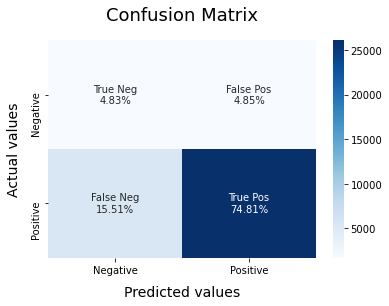

In [202]:
# Printing out the Evaluation metrics. 
ConfusionMatrix(df['y_pred'], df['y_test'])

In [249]:
df.to_csv('sahel_jul_aug_2020_en_all_clean_with_sentiment-cities.csv')

In [215]:
df['sentiment']=df['y_pred'].apply(lambda x: 'pos' if x>0 else 'neg')

In [246]:
fig=px.histogram(df,x="sentiment",color = "sentiment", color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(xaxis_title='sentiment',title='All tweets')
fig.show()

In [247]:
df['y_test_1']= df['y_pred']

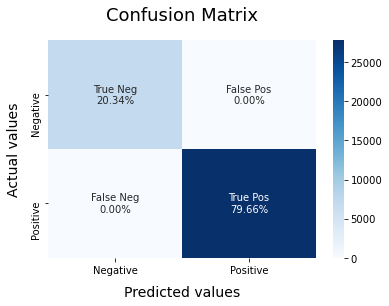

In [248]:
# Printing out the Evaluation metrics. 
ConfusionMatrix(df['y_pred'], df['y_test_1'])

In [262]:
df

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,y_test_1,sentiment
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1,1,pos
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1,1,pos
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1,1,pos
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1,0,neg
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1,0,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,2020-06-01 03:39:08 CEST,2020-06-01 00:00:00,2021-11-14 03:39:08,2020,6,1,3,Ouagadougou,"@ifeafolayann I agree with this, because it ta...",pos,<user> i agree with this because it take a ma...,1,1,1,pos
34864,2020-06-01 03:29:14 CEST,2020-06-01 00:00:00,2021-11-14 03:29:14,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor Advice***,pos,<user> <user> advice,1,1,1,pos
34865,2020-06-01 03:27:08 CEST,2020-06-01 00:00:00,2021-11-14 03:27:08,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor If this advise c...,pos,<user> <user> if this advise can prevent futur...,1,1,1,pos
34866,2020-06-01 03:22:43 CEST,2020-06-01 00:00:00,2021-11-14 03:22:43,2020,6,1,3,Ouagadougou,@Ms_Haesha @OoasWaho @DrTedros @MoetiTshidi @J...,pos,<user> <user> <user> <user> <user> <user> <use...,1,1,1,pos


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      34868 non-null  object
 1   date            34868 non-null  object
 2   time            34868 non-null  object
 3   year            34868 non-null  int64 
 4   month           34868 non-null  int64 
 5   day             34868 non-null  int64 
 6   hour            34868 non-null  int64 
 7   city            34868 non-null  object
 8   tweet           34868 non-null  object
 9   polarity        34868 non-null  object
 10  processed_text  34868 non-null  object
 11  y_pred          34868 non-null  int64 
 12  y_test          34868 non-null  int64 
 13  y_test_1        34868 non-null  int64 
 14  sentiment       34868 non-null  object
dtypes: int64(7), object(8)
memory usage: 4.0+ MB


In [ ]:
#df['date1'] = pd.to_datetime(df.date)
#df['times'] = pd.to_datetime(df.time)


In [ ]:
#df['day'] = df['date1'].dt.day
#df['month'] = df['date1'].dt.month
#df['hour'] = df['times'].dt.hour

In [264]:
df

,created_at,date,time,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,y_test_1,sentiment
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2021-11-14 01:59:10,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1,1,pos
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2021-11-14 01:58:48,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1,1,pos
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2021-11-14 01:57:49,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1,1,pos
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2021-11-14 01:50:46,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1,0,neg
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2021-11-14 01:42:53,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1,0,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,2020-06-01 03:39:08 CEST,2020-06-01 00:00:00,2021-11-14 03:39:08,2020,6,1,3,Ouagadougou,"@ifeafolayann I agree with this, because it ta...",pos,<user> i agree with this because it take a ma...,1,1,1,pos
34864,2020-06-01 03:29:14 CEST,2020-06-01 00:00:00,2021-11-14 03:29:14,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor Advice***,pos,<user> <user> advice,1,1,1,pos
34865,2020-06-01 03:27:08 CEST,2020-06-01 00:00:00,2021-11-14 03:27:08,2020,6,1,3,Ouagadougou,@scad_official @aproko_doctor If this advise c...,pos,<user> <user> if this advise can prevent futur...,1,1,1,pos
34866,2020-06-01 03:22:43 CEST,2020-06-01 00:00:00,2021-11-14 03:22:43,2020,6,1,3,Ouagadougou,@Ms_Haesha @OoasWaho @DrTedros @MoetiTshidi @J...,pos,<user> <user> <user> <user> <user> <user> <use...,1,1,1,pos


In [265]:
df_2 = df.drop(['y_test_1', 'time'], axis=1)

In [266]:
df.to_csv('sahel_jul_aug_20_en_clean_with_sentiment_date-liptako-cities.csv')

In [267]:
df_2.head()

,created_at,date,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,sentiment
0,2020-08-31 01:59:10 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Sakiniah_bawa Wlhy or Ã°ÂÂ¤Â£ Ã°ÂÂ¤Â£ Ã°ÂÂ...,pos,<user> wlhy or,1,1,pos
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1,pos
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1,pos
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1,neg
4,2020-08-31 01:42:53 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@galow_rex @__usyy Ã°ÂÂÂ¶Ã¢ÂÂÃ¢ÂÂÃ¯Â¸ÂÃ...,pos,<user> <user> ...,0,1,neg


In [268]:
df_3 = df_2.sort_values(by=['created_at'])

In [269]:
df_3.head()

,created_at,date,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,sentiment
25358,2020-06-01 02:12:22 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,Hi hi quickly enjoy for this online business t...,pos,hi hi quickly enjoy for this online business t...,1,1,pos
25357,2020-06-01 02:19:07 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@lance458 Allahumma amen. Thank you, i really ...",pos,<user> allahumma amen thank you i really app...,1,1,pos
34867,2020-06-01 02:20:13 CEST,2020-06-01 00:00:00,2020,6,1,2,Ouagadougou,With PGI,pos,with pgi,1,1,pos
25356,2020-06-01 02:42:05 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@SaifRikiji Serious, indeed",neg,<user> serious indeed,0,0,neg
25355,2020-06-01 02:43:03 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,May Allah make it easy for us,pos,may allah make it easy for us,1,1,pos


In [273]:
df_3

,created_at,date,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,sentiment
25358,2020-06-01 02:12:22 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,Hi hi quickly enjoy for this online business t...,pos,hi hi quickly enjoy for this online business t...,1,1,pos
25357,2020-06-01 02:19:07 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@lance458 Allahumma amen. Thank you, i really ...",pos,<user> allahumma amen thank you i really app...,1,1,pos
34867,2020-06-01 02:20:13 CEST,2020-06-01 00:00:00,2020,6,1,2,Ouagadougou,With PGI,pos,with pgi,1,1,pos
25356,2020-06-01 02:42:05 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@SaifRikiji Serious, indeed",neg,<user> serious indeed,0,0,neg
25355,2020-06-01 02:43:03 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,May Allah make it easy for us,pos,may allah make it easy for us,1,1,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26267,2020-08-31 01:44:43 CEST,2020-08-31 00:00:00,2020,8,31,1,Ouagadougou,@Raadyalongo guys were all serious heavy ÃÂ°Ã...,neg,<user> guys were all serious heavy ...,1,0,pos
3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1,neg
2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1,pos
1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1,pos


In [274]:
df_3.to_csv('sahel_jul_aug_2020_en_clean_with_sentiment_date_sorted-Lip-cities.csv')